# Vector Autoregression (VAR) Analysis of Apple Watch Health Data

This notebook performs VAR analysis on daily health metrics to understand:
- How health variables influence each other over time
- Granger causality relationships (does X predict Y?)
- How shocks propagate through the system (Impulse Response Functions)
- What proportion of variance in each variable is explained by others (FEVD)

## 1. Setup and Data Loading

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [25]:
# Load raw HealthKit data
df = pd.read_csv('data/health_records.csv', low_memory=False)
print(f"Total records: {len(df):,}")
print(f"Date range: {df['startDate'].min()} to {df['startDate'].max()}")

Total records: 2,795,078
Date range: 2012-04-20 00:00:00 -0400 to 2023-03-18 00:09:49 -0400


In [26]:
# Filter to Apple Watch data only
device_df = df[df.sourceName =="Rob’s Apple\xa0Watch"].copy()
print(f"Apple Watch records: {len(device_df):,}")

Apple Watch records: 2,297,164


In [27]:
def correct_and_localize_timestamp(series: pd.Series, timezone: str = 'America/New_York') -> pd.Series:
    """
    Corrects HealthKit timestamps by stripping unreliable offsets and re-localizing.
    
    HealthKit exports often use a fixed offset based on export time,
    incorrectly applying it to dates in different seasons.
    """
    datetimes = pd.to_datetime(series)
    naive_datetimes = datetimes.dt.tz_localize(None)
    return naive_datetimes.dt.tz_localize(timezone, ambiguous=True, nonexistent='shift_forward')

# Apply timezone correction
device_df['creationDate'] = correct_and_localize_timestamp(device_df['creationDate'])
device_df['startDate'] = correct_and_localize_timestamp(device_df['startDate'])
device_df['endDate'] = correct_and_localize_timestamp(device_df['endDate'])

# Filter out records spanning > 1 hour
delta = device_df['endDate'] - device_df['startDate']
device_df = device_df[delta <= pd.Timedelta(hours=1)]
device_df.index = device_df.startDate

print(f"Records after filtering: {len(device_df):,}")

Records after filtering: 2,295,350


In [28]:
# Define the 5 core metrics for VAR analysis
metrics_config = {
    'HKQuantityTypeIdentifierStepCount': ('sum', 'Steps'),
    'HKQuantityTypeIdentifierAppleExerciseTime': ('sum', 'ExerciseTime'),
    'HKQuantityTypeIdentifierHeartRate': ('mean', 'HeartRate'),
    'HKQuantityTypeIdentifierHeartRateVariabilitySDNN': ('mean', 'HRV'),
    'HKQuantityTypeIdentifierActiveEnergyBurned': ('sum', 'ActiveEnergy'),
}

# Aggregate to daily values
daily_data = {}
for metric, (agg_method, short_name) in metrics_config.items():
    subset = pd.to_numeric(device_df[device_df.type == metric]['value'], errors='coerce')
    if agg_method == 'sum':
        daily_data[short_name] = subset.resample('D').sum()
    else:
        daily_data[short_name] = subset.resample('D').mean()

daily_df = pd.DataFrame(daily_data)
print(f"Daily observations: {len(daily_df)}")
print(f"\nDate range: {daily_df.index.min().date()} to {daily_df.index.max().date()}")
daily_df.head()

Daily observations: 905

Date range: 2020-09-25 to 2023-03-18


,Steps,ExerciseTime,HeartRate,HRV,ActiveEnergy
startDate,,,,,
2020-09-25 00:00:00-04:00,750.0,1.0,63.333563,78.674450,142.219
2020-09-26 00:00:00-04:00,12284.0,105.0,96.925524,56.330725,1380.714
2020-09-27 00:00:00-04:00,8057.0,59.0,62.674077,61.245689,784.015
2020-09-28 00:00:00-04:00,13561.0,72.0,120.857667,72.409940,1304.451
2020-09-29 00:00:00-04:00,4207.0,25.0,63.534644,50.930600,511.712


In [29]:
# Outlier removal using 2.5 IQR
Q1 = daily_df.quantile(0.25)
Q3 = daily_df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

outliers_before = daily_df.isna().sum()
daily_df = daily_df.mask((daily_df < lower_bound) | (daily_df > upper_bound))
outliers_after = daily_df.isna().sum()

print("Missing values (including outliers removed):")
print(daily_df.isna().sum())

Missing values (including outliers removed):
Steps            21
ExerciseTime     23
HeartRate       108
HRV              12
ActiveEnergy     44
dtype: int64


In [ ]:
# Handle missing data: linear interpolation for small gaps
# First, drop rows where all values are NaN (e.g., incomplete days at start/end)
daily_df = daily_df.dropna(how='all')

# Interpolate small gaps (up to 3 consecutive days)
daily_df = daily_df.interpolate(method='linear', limit=3)

# Drop remaining rows with any NaN (required for VAR)
var_df = daily_df.dropna()

# Reorder columns for Cholesky decomposition (used in orthogonalized IRFs/FEVD)
# Ordering reflects causal assumptions: behavioral → physiological → derived
cholesky_order = ['ExerciseTime', 'Steps', 'HeartRate', 'ActiveEnergy', 'HRV']
var_df = var_df[cholesky_order]

print(f"Observations for VAR analysis: {len(var_df)}")
print(f"Variables (Cholesky order): {list(var_df.columns)}")
print("\nCholesky ordering assumption:")
print("  1. ExerciseTime, Steps: Volitional behaviors (most exogenous)")
print("  2. HeartRate: Physiological response to activity")
print("  3. ActiveEnergy: Derived from HR + movement sensors")
print("  4. HRV: Autonomic response (most downstream)")

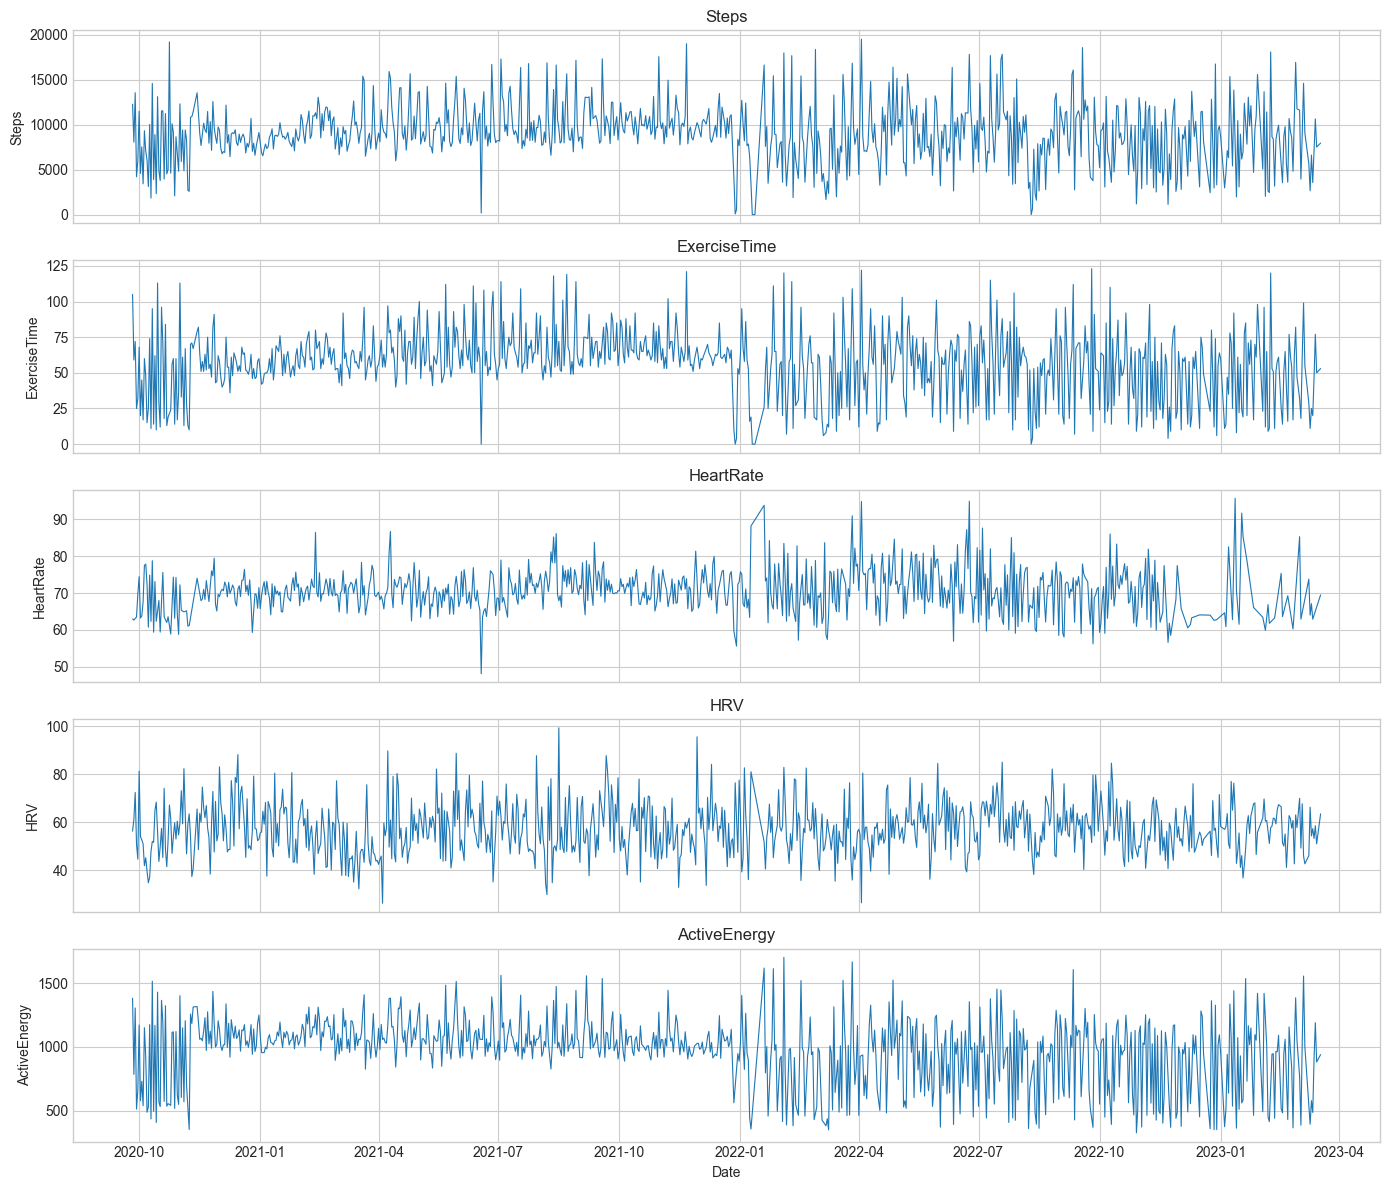

In [31]:
# Visualize all time series
fig, axes = plt.subplots(len(var_df.columns), 1, figsize=(14, 12), sharex=True)

for i, col in enumerate(var_df.columns):
    axes[i].plot(var_df.index, var_df[col], linewidth=0.8)
    axes[i].set_ylabel(col)
    axes[i].set_title(col)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

## 2. Stationarity Testing

VAR assumes stationarity. We use the Augmented Dickey-Fuller (ADF) test:
- **Null hypothesis**: The series has a unit root (non-stationary)
- **p < 0.05**: Reject null → series is stationary

In [32]:
def adf_test(series, name):
    """Run ADF test and return results as dict."""
    result = adfuller(series.dropna(), autolag='AIC')
    return {
        'Variable': name,
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Stationary': 'Yes' if result[1] < 0.05 else 'No'
    }

# Test all variables
adf_results = [adf_test(var_df[col], col) for col in var_df.columns]
adf_df = pd.DataFrame(adf_results)
print("ADF Test Results (Original Series):")
print(adf_df.to_string(index=False))

ADF Test Results (Original Series):
    Variable  ADF Statistic      p-value  Lags Used Stationary
       Steps      -4.500196 1.964799e-04         21        Yes
ExerciseTime      -2.943984 4.046711e-02         20        Yes
   HeartRate      -5.633316 1.077078e-06         14        Yes
         HRV     -12.417472 4.209050e-23          3        Yes
ActiveEnergy      -2.640882 8.483862e-02         20         No


In [33]:
# If any series is non-stationary, apply first differencing
non_stationary = adf_df[adf_df['Stationary'] == 'No']['Variable'].tolist()

if non_stationary:
    print(f"Non-stationary series: {non_stationary}")
    print("Applying first differencing...")
    
    # Difference the entire dataset for consistency
    var_df_diff = var_df.diff().dropna()
    
    # Re-test after differencing
    adf_results_diff = [adf_test(var_df_diff[col], col) for col in var_df_diff.columns]
    adf_df_diff = pd.DataFrame(adf_results_diff)
    print("\nADF Test Results (After Differencing):")
    print(adf_df_diff.to_string(index=False))
    
    # Use differenced data if needed
    use_differenced = True
else:
    print("All series are stationary. No differencing needed.")
    var_df_diff = var_df
    use_differenced = False

Non-stationary series: ['ActiveEnergy']
Applying first differencing...

ADF Test Results (After Differencing):
    Variable  ADF Statistic      p-value  Lags Used Stationary
       Steps      -9.432861 5.134208e-16         20        Yes
ExerciseTime     -11.370653 8.996713e-21         19        Yes
   HeartRate     -10.341468 2.678301e-18         19        Yes
         HRV     -11.762742 1.137743e-21         17        Yes
ActiveEnergy     -10.673936 4.099586e-19         21        Yes


## 3. VAR Model Fitting

In [34]:
# Select data based on stationarity results
model_data = var_df_diff if use_differenced else var_df

# Fit VAR model and select optimal lag using information criteria
model = VAR(model_data)
lag_order_results = model.select_order(maxlags=7)
print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       41.68       41.71   1.268e+18       41.69
1       40.52       40.69   3.962e+17       40.58
2       40.12       40.43   2.667e+17       40.24
3       39.83       40.27   1.982e+17       40.00
4       39.69      40.26*   1.721e+17       39.91
5       39.57       40.29   1.536e+17       39.85
6       39.45       40.30   1.363e+17       39.78
7      39.40*       40.39  1.291e+17*      39.78*
-------------------------------------------------


In [35]:
# Fit VAR with AIC-optimal lag order
optimal_lag = lag_order_results.aic
print(f"Optimal lag order (AIC): {optimal_lag}")

results = model.fit(optimal_lag)
print(f"\nModel fitted with {optimal_lag} lags")
print(f"Parameters per equation: {results.k_ar * len(model_data.columns) + 1}")
print(f"Total observations: {results.nobs}")

Optimal lag order (AIC): 7

Model fitted with 7 lags
Parameters per equation: 36
Total observations: 869


In [36]:
# Display model summary
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 30, Nov, 2025
Time:                     21:36:46
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    40.3869
Nobs:                     869.000    HQIC:                   39.7773
Log likelihood:          -23104.3    FPE:                1.29138e+17
AIC:                      39.3994    Det(Omega_mle):     1.05417e+17
--------------------------------------------------------------------
Results for equation Steps
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -3.242072       110.058708           -0.029           0.976
L1.Steps               -0.686291         0.065465          -10.483           0.000
L1.ExerciseTime       -29.289072         9.259092   

In [37]:
# Model diagnostics
print("=" * 60)
print("MODEL DIAGNOSTICS")
print("=" * 60)

# Durbin-Watson statistic (should be close to 2 for no autocorrelation)
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(results.resid)
print("\nDurbin-Watson Statistics (ideal ≈ 2):")
for i, col in enumerate(model_data.columns):
    print(f"  {col}: {dw[i]:.3f}")

# Stability check - all eigenvalues should be inside unit circle
print(f"\nStability: {'Stable' if results.is_stable() else 'UNSTABLE'}")

MODEL DIAGNOSTICS

Durbin-Watson Statistics (ideal ≈ 2):
  Steps: 2.015
  ExerciseTime: 2.022
  HeartRate: 2.014
  HRV: 2.024
  ActiveEnergy: 2.025

Stability: Stable


## 4. Granger Causality Tests

Granger causality tests whether past values of X help predict Y beyond Y's own past.
- **Null hypothesis**: X does NOT Granger-cause Y
- **p < 0.05**: Reject null → X Granger-causes Y

In [38]:
# Run Granger causality tests for all pairs
variables = list(model_data.columns)
granger_matrix = pd.DataFrame(index=variables, columns=variables, dtype=float)

for response in variables:
    for predictor in variables:
        if response != predictor:
            test_result = results.test_causality(response, causing=predictor, kind='f')
            granger_matrix.loc[response, predictor] = test_result.pvalue
        else:
            granger_matrix.loc[response, predictor] = np.nan

print("Granger Causality p-values (column → row):")
print("Values < 0.05 indicate significant Granger causality")
print(granger_matrix.round(4))

Granger Causality p-values (column → row):
Values < 0.05 indicate significant Granger causality
               Steps  ExerciseTime  HeartRate     HRV  ActiveEnergy
Steps            NaN        0.0578     0.1542  0.8286        0.9681
ExerciseTime  0.0439           NaN     0.1194  0.9494        0.8387
HeartRate     0.2825        0.1095        NaN  0.2523        0.3680
HRV           0.8436        0.2013     0.5314     NaN        0.4030
ActiveEnergy  0.4164        0.0364     0.0232  0.9961           NaN


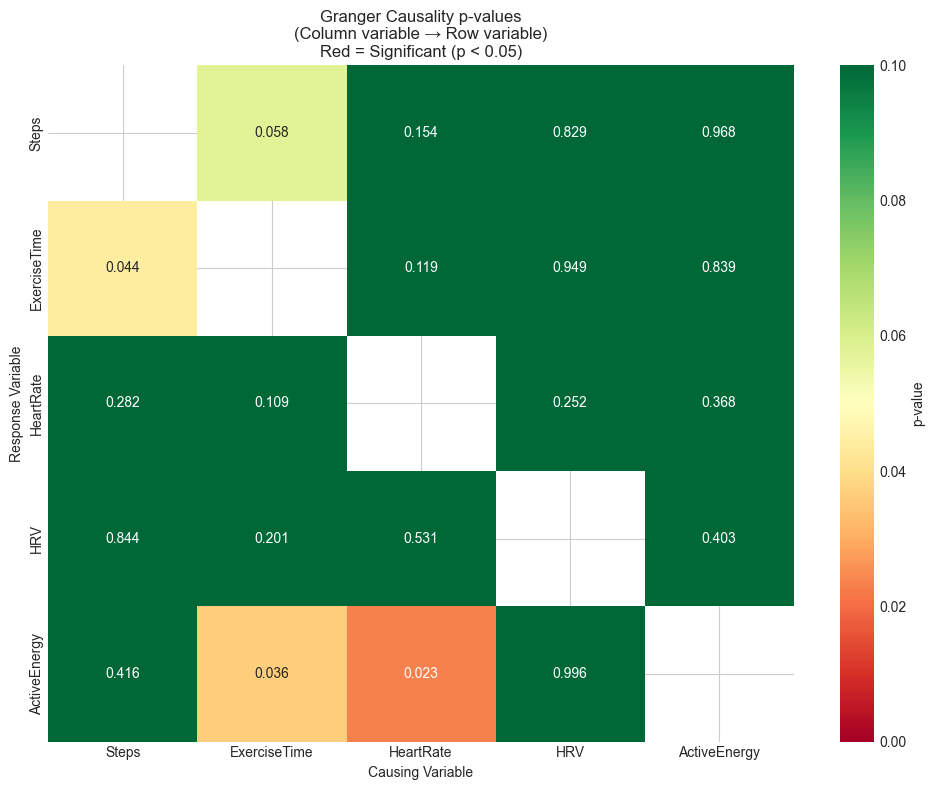


Significant Granger Causality Relationships (p < 0.05):
  Steps → ExerciseTime: p = 0.0439
  ExerciseTime → ActiveEnergy: p = 0.0364
  HeartRate → ActiveEnergy: p = 0.0232


In [39]:
# Visualize as heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Create mask for diagonal
mask = np.eye(len(variables), dtype=bool)

# Plot heatmap (lower values = stronger evidence of Granger causality)
sns.heatmap(granger_matrix.astype(float), 
            annot=True, fmt='.3f', 
            cmap='RdYlGn',  # Red = low p-value = significant
            mask=mask,
            vmin=0, vmax=0.1,
            ax=ax,
            cbar_kws={'label': 'p-value'})

ax.set_title('Granger Causality p-values\n(Column variable → Row variable)\nRed = Significant (p < 0.05)')
ax.set_xlabel('Causing Variable')
ax.set_ylabel('Response Variable')
plt.tight_layout()
plt.show()

# List significant relationships
print("\nSignificant Granger Causality Relationships (p < 0.05):")
for response in variables:
    for predictor in variables:
        if response != predictor:
            pval = granger_matrix.loc[response, predictor]
            if pval < 0.05:
                print(f"  {predictor} → {response}: p = {pval:.4f}")

## 5. Impulse Response Functions (IRFs)

IRFs show how a one-standard-deviation shock to one variable propagates through the system over time.

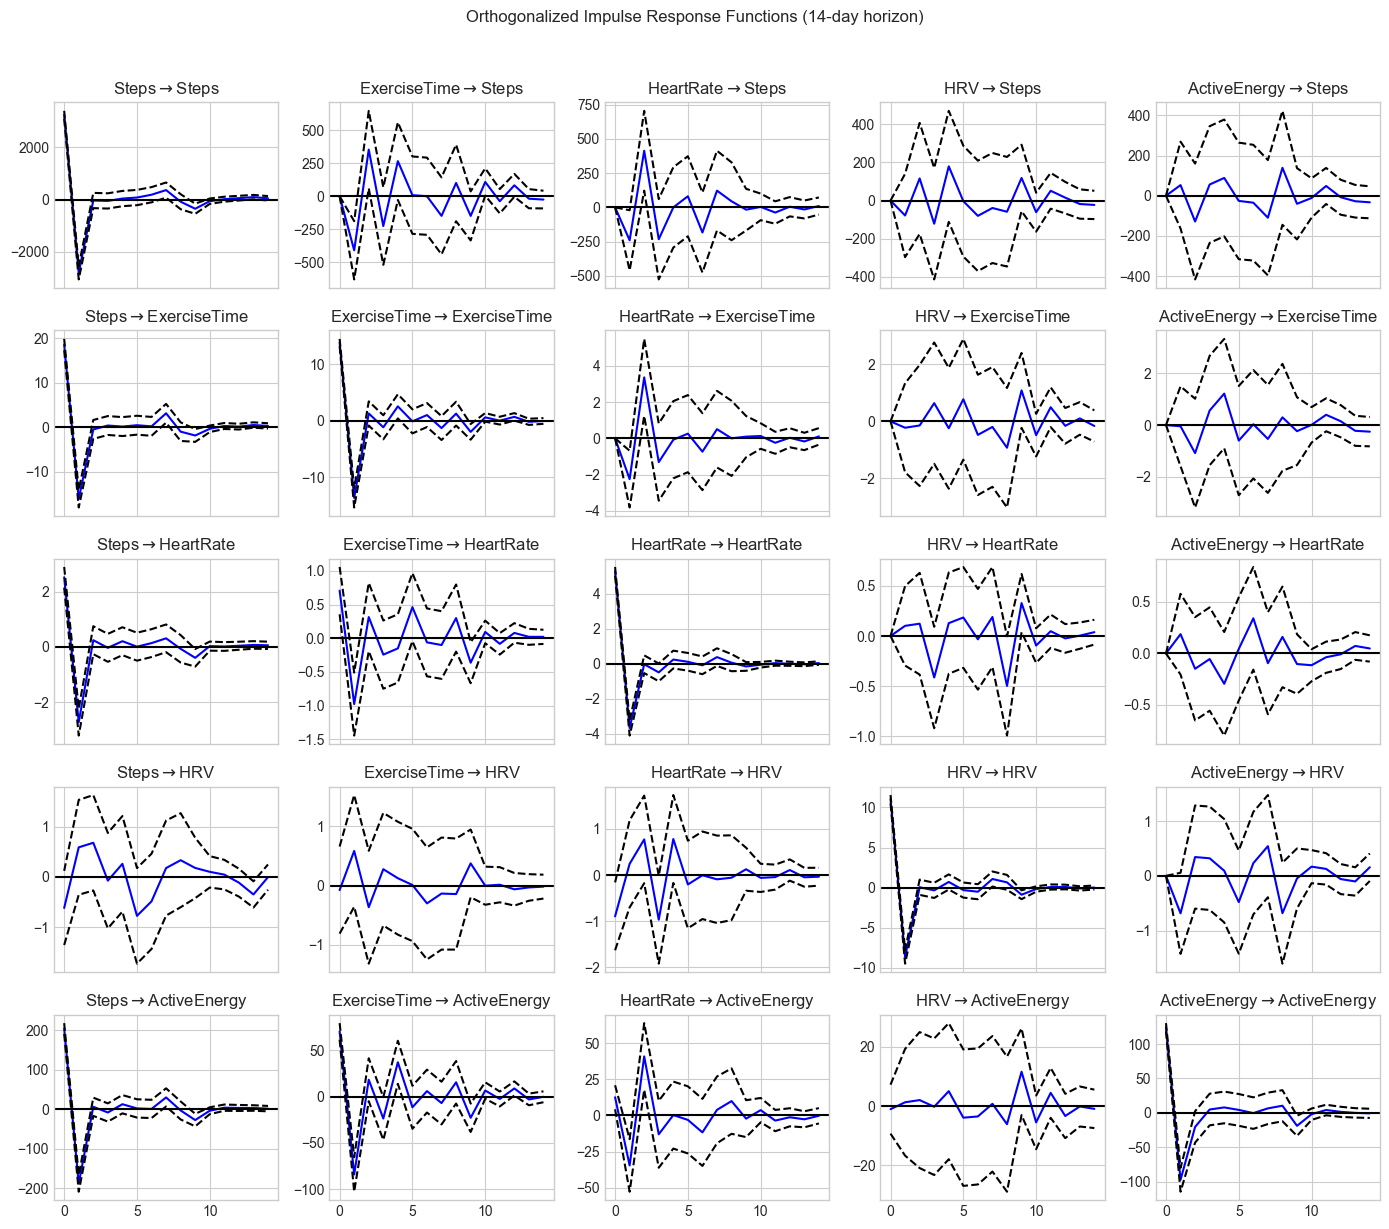

In [40]:
# Compute IRFs for 14-day horizon
irf = results.irf(periods=14)

# Plot all IRFs
fig = irf.plot(orth=True, figsize=(14, 12))
plt.suptitle('Orthogonalized Impulse Response Functions (14-day horizon)', y=1.02)
plt.tight_layout()
plt.show()

## 7. Summary and Interpretation

In [41]:
print("="*60)
print("VAR ANALYSIS SUMMARY")
print("="*60)

print(f"\n1. DATA")
print(f"   - Observations: {len(model_data)}")
print(f"   - Variables: {', '.join(variables)}")
print(f"   - Differenced: {'Yes' if use_differenced else 'No'}")

print(f"\n2. MODEL")
print(f"   - Optimal lag order (AIC): {optimal_lag}")
print(f"   - Model stability: {'Stable' if results.is_stable() else 'UNSTABLE'}")

print(f"\n3. KEY GRANGER CAUSALITY FINDINGS")
sig_count = 0
for response in variables:
    for predictor in variables:
        if response != predictor:
            pval = granger_matrix.loc[response, predictor]
            if pval < 0.05:
                sig_count += 1
                print(f"   - {predictor} Granger-causes {response} (p={pval:.4f})")
if sig_count == 0:
    print("   - No significant Granger causality relationships at p<0.05")

print(f"\n4. LIMITATIONS")
print("   - VAR assumes linear relationships only")
print("   - Granger causality ≠ true causality (confounders possible)")
print("   - Relationships assumed time-invariant")
print("   - N=1 study: results specific to this individual")

VAR ANALYSIS SUMMARY

1. DATA
   - Observations: 876
   - Variables: Steps, ExerciseTime, HeartRate, HRV, ActiveEnergy
   - Differenced: Yes

2. MODEL
   - Optimal lag order (AIC): 7
   - Model stability: Stable

3. KEY GRANGER CAUSALITY FINDINGS
   - Steps Granger-causes ExerciseTime (p=0.0439)
   - ExerciseTime Granger-causes ActiveEnergy (p=0.0364)
   - HeartRate Granger-causes ActiveEnergy (p=0.0232)

4. LIMITATIONS
   - VAR assumes linear relationships only
   - Granger causality ≠ true causality (confounders possible)
   - Relationships assumed time-invariant
   - N=1 study: results specific to this individual


### Interpretation Guide

**Granger Causality**: If Exercise Granger-causes HRV, it means past exercise values help predict future HRV *beyond* what HRV's own past predicts. This suggests (but doesn't prove) a causal relationship.

**IRFs**: The impulse response shows how the system responds over time to a one-time shock. For example, if the Exercise→HRV IRF shows a positive spike on day 2 then returns to zero, it suggests exercise has a delayed positive effect on HRV that dissipates quickly.

**FEVD**: If 30% of HRV variance is explained by Exercise at the 7-day horizon, it means that out of all forecast uncertainty in HRV, about 30% comes from uncertainty about what Exercise will do.

**Next Steps**:
- If nonlinear relationships suspected: try Threshold VAR or Convergent Cross Mapping
- If sample size is limited: use Bayesian VAR with Minnesota priors
- For intervention analysis: consider CausalImpact or interrupted time series